In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import Can_Algorithms_v2 as alg
import numpy as nmp
import logging as log
import datetime
import os
import umap
import seaborn as sns  # for visualizing the confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

class ScanResult:
    def __init__(self, model, precision, recall, f1_score, support):
        self.model=model
        self.precision = precision
        self.recall = recall
        self.f1_score = f1_score
        self.support=support

dsType="fuzzy"
data_folder="Dataset/CleanDataset/"
dos_dataPath=data_folder+"Cleaned_DoS_dataset.csv"
fuzzy_dataPath=data_folder+"Cleaned_fuzzy_dataset.csv"
gear_dataPath=data_folder+"Cleaned_gear_dataset.csv"
rpm_dataPath=data_folder+"Cleaned_RPM_dataset.csv"
normal_dataPath=data_folder+"Cleaned_normal_dataset.csv"
fuzzy_dataPath="Dataset/TestDataset/1000doS_dataset.csv"




datasets = ['fuzzy']# Set your datasets to run Options are: dos, fuzzy, gear, rpm
# Create a folder for log files if it doesn't exist
log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)
# Configure logging to save log file in the folder
log_file = os.path.join(log_folder, 'log_file.txt')

# Configure logging
log.basicConfig(filename=log_file,
                level=log.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def CleanData(filePath):
    # Read the file line by line
    with open(filePath, 'r') as file:
        lines = file.readlines()

    # Process each line and store the results in a list
    processed_lines = []
    for line in lines:
        # Split the line by comma
        parts = line.strip().split(',')
        # Parse the timestamp
        timestamp = pd.to_datetime(float(parts[0]), unit='s')
        num_zeros = 12 - len(parts)
        flag_position = len(parts) - 1
        # Move the last value to the last index and fill zeros in between
        processed_line = parts[:flag_position] + ['00'] * num_zeros + [parts[flag_position]]
        # Append the processed line to the list
        processed_lines.append(processed_line)

    # Convert the list of processed lines into a DataFrame
    data = pd.DataFrame(processed_lines)
    return data

#Function to convert hex string to integer
def hex_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return nmp.nan
    else:
        return x

def getDate():
    current_ts = datetime.datetime.now()
    formatted_time= current_ts.strftime("%Y-%m-%d %H:%M:%S")
    return current_ts,formatted_time

def PreprocessData(data, testSize=0.2):        
        # Assign column names
        data.columns = ['Timestamp', 'CAN_ID', 'DLC', 'DATA0', 'DATA1',
                        'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']

        # Convert Flag column to numerical labels using label encoding
        label_encoder = LabelEncoder()
        data['Flag'] = label_encoder.fit_transform(data['Flag'])

        data["Timestamp"] = pd.to_datetime(data["Timestamp"])

        # Convert CAN ID and DLC to integer
        data["CAN_ID"] = data["CAN_ID"].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
        data["DLC"] = data["DLC"].astype(int)
       
        # Convert DATA fields from hexadecimal strings to integers
        for i in range(8):
            data[f"DATA{i}"] = data[f"DATA{i}"].apply(hex_to_int).astype(float)

        # Assuming 'Flag' column represents the target variable
        X = data.drop('Flag', axis=1)  # Features
        # X = data[['CAN_ID'],['DATA0']]
        # X = data[['CAN_ID', 'Flag']]
        y = data['Flag']  # Target variable

        unique_classes = nmp.unique(y)
        print("Unique classes in the dataset:", unique_classes)
        # Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=42)
       
        # Drop 'Timestamp' column from input features
        X_train = X_train.drop('Timestamp', axis=1)
        X_test = X_test.drop('Timestamp', axis=1)
       
        # Impute missing values using SimpleImputer
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        print("X train imputed")
        print(X_train_imputed)
        print(X_test_imputed)
        return X,X_train,X_test,X_train_imputed,X_test_imputed,y_train,y_test, label_encoder.classes_

def PlotBarGraph(models,metrics,values,title,x_label,y_label):
    # Plotting
    plt.figure(figsize=(5,3))

    # Plot bars for each metric and model
    bar_width = 0.2
    index = nmp.arange(len(models))

    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[i], bar_width, label=metric)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(index + bar_width * 1.5, models)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def PlotLineGraph(models,metrics,values,title,x_label,y_label):
    # Plot curved lines for each metric and model
    for i, metric in enumerate(metrics):
        f = interp1d(nmp.arange(len(models)), values[i], kind='cubic')
        x_new = nmp.linspace(0, len(models) - 1, 100)
        y_new = f(x_new)
        plt.plot(x_new, y_new, label=metric)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(nmp.arange(len(models)), models)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix with specified labels for normal and attack traffic.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Ensure labels are in the correct order: [Normal, Attack]
    classes = ['Normal', 'Attack']

    # Print confusion matrix values
    print('Confusion matrix, without normalization')
    print(cm)

    # Plotting
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax, xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    plt.show()

def plot_attack_scatter(y_true, y_pred):
    """
    This function plots a scatter diagram of the actual vs. predicted attack/normal status.
    """
    plt.figure(figsize=(10, 6))
    indices = nmp.arange(len(y_true))  # Generate indices for x-axis

    # Plotting actual values
    plt.scatter(indices, y_true, color='blue', alpha=0.5, marker='o', label='Actual')

    # Plotting predicted values
    plt.scatter(indices, y_pred, color='red', alpha=0.5, marker='x', label='Predicted')

    plt.title('Scatter Plot of Actual vs. Predicted Attacks/Normal Traffic')
    plt.xlabel('Sample Index')
    plt.ylabel('Attack Status (1 for Attack, 0 for Normal)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_tsne(X, y_true, y_pred, perplexity=30, n_components=2, learning_rate=200):
    """
    Function to plot t-SNE with actual and predicted labels.
    Args:
    - X: Feature matrix.
    - y_true: Actual labels.
    - y_pred: Predicted labels.
    - perplexity: t-SNE perplexity parameter.
    - n_components: Number of dimensions t-SNE should reduce to.
    - learning_rate: t-SNE learning rate.
    """
    # Initialize t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    
    # Fit and transform the data
    X_tsne = tsne.fit_transform(X)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    
    # Plot actual labels
    plt.subplot(1, 2, 1)
    for cls in nmp.unique(y_true):
        plt.scatter(X_tsne[y_true == cls, 0], X_tsne[y_true == cls, 1], label=f'Actual {cls}', alpha=0.5)
    plt.title('t-SNE based on Actual Labels')
    plt.legend()
    
    # Plot predicted labels
    plt.subplot(1, 2, 2)
    for cls in nmp.unique(y_pred):
        plt.scatter(X_tsne[y_pred == cls, 0], X_tsne[y_pred == cls, 1], label=f'Predicted {cls}', alpha=0.5)
    plt.title('t-SNE based on Predicted Labels')
    plt.legend()

    plt.show()

def plot_umap(X, y_true, y_pred, n_neighbors=15, min_dist=0.1, n_components=2):
    """
    Function to plot UMAP with actual and predicted labels.
    Args:
    - X: Feature matrix.
    - y_true: Actual labels.
    - y_pred: Predicted labels.
    - n_neighbors: The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    - min_dist: The minimum distance apart that points are allowed to be in the low-dimensional representation.
    - n_components: Number of dimensions UMAP should reduce to.
    """
    # Initialize UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    
    # Fit and transform the data
    X_umap = reducer.fit_transform(X)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    
    # Plot actual labels
    plt.subplot(1, 2, 1)
    for cls in nmp.unique(y_true):
        plt.scatter(X_umap[y_true == cls, 0], X_umap[y_true == cls, 1], label=f'Actual {cls}', alpha=0.5)
    plt.title('UMAP based on Actual Labels')
    plt.legend()
    
    # Plot predicted labels
    plt.subplot(1, 2, 2)
    for cls in nmp.unique(y_pred):
        plt.scatter(X_umap[y_pred == cls, 0], X_umap[y_pred == cls, 1], label=f'Predicted {cls}', alpha=0.5)
    plt.title('UMAP based on Predicted Labels')
    plt.legend()

    plt.show()

Dataset cleaned-----------
Unique classes in the dataset: [0 1]
X train imputed
[[ 672.    8.   68. ...    2.  189.    0.]
 [ 305.    8.   37. ...  127.    7.   47.]
 [1349.    8.  216. ...    0.    0.    0.]
 ...
 [   0.    8.    0. ...    0.    0.    0.]
 [   0.    8.    0. ...    0.    0.    0.]
 [ 704.    8.   20. ...    0.    0.    0.]]
[[1349.    8.  216. ...    0.    0.    0.]
 [ 880.    8.    0. ...    0.    0.    0.]
 [ 790.    8.    5. ...   33.    0.  111.]
 ...
 [   0.    8.    0. ...    0.    0.    0.]
 [   0.    8.    0. ...    0.    0.    0.]
 [   0.    8.    0. ...    0.    0.    0.]]
-------------------------------
Model:  CNN
-------------------------------
Starting CNN model...
X_train completed
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--Report for CNN--
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       1.00      1.00      1.00       366

    accuracy                           1.00      1000


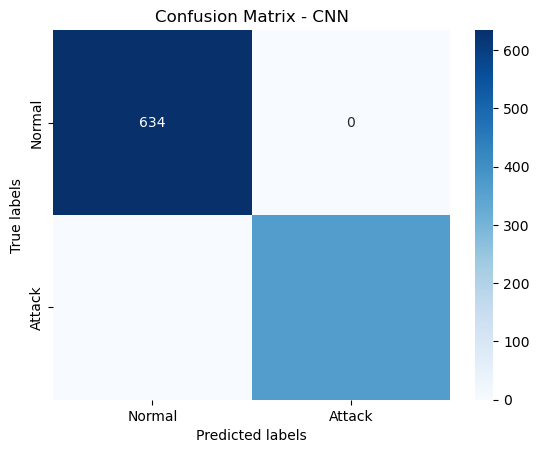

Precision: 1.0
Recall: 1.0
f1 score: 1.0
Support: 0.634
[[1.0], [1.0], [1.0], [0.634]]


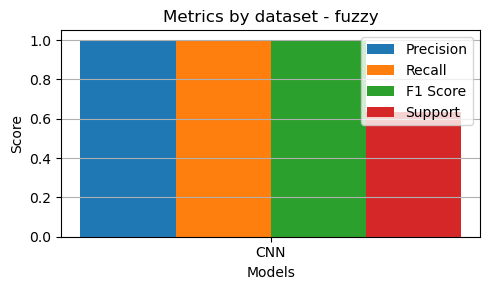

In [8]:
dataPath=""
for ds_name in datasets:
    log.info("#####################################")
    log.info("Running dataset: [%s]",ds_name)
    log.info("#####################################")

    dataPath=dos_dataPath
    if ds_name=='fuzzy':
        dataPath=fuzzy_dataPath
    elif ds_name=='gear':
        dataPath=gear_dataPath
    elif ds_name=='rpm':
        dataPath=rpm_dataPath
    elif ds_name=='normal':
        dataPath=normal_dataPath

    #Load Data
    ds = pd.read_csv(dataPath, header=None)
    # ds = CleanData(dataPath)
    print('Dataset cleaned-----------')
    X,X_train,X_test,X_train_imputed,X_test_imputed,y_train,y_test,class_labels=PreprocessData(ds,0.2)

    # Define the models and their corresponding metrics
    # models =  ['MLP','SGD','LRG','CNN']
    models = ['CNN']

    precision = []
    recall = []
    f1_score = []
    support = []
    results =[]
    
    metrics=[]
    values=[]
    # Calculate total number of samples in the test set
    total_samples = len(y_test)

    # Run and evaluate each model
    for model_name in models:
        print('-------------------------------')
        print('Model: ',model_name)
        print('-------------------------------')
        if 1==1:
            if model_name == 'SVC':
                start_ts,formatted_start_ts = getDate()
                log.info("Starting SVC model...[%s]",formatted_start_ts)
                y_pred = alg.SVC_Scan(X_train_imputed, y_train, X_test_imputed)
                end_ts,formatted_end_ts = getDate()
                log.info('SVC model finished. Elapsed time: %s',
                end_ts - start_ts)    
            elif model_name == 'LOGR':
                start_ts,formatted_start_ts = getDate()
                log.info("Starting Logistic regression model...[%s]",formatted_start_ts)
                y_pred = alg.Logistic_regression_Scan(X_train_imputed, y_train, X_test_imputed)    
                end_ts,formatted_end_ts = getDate()
                log.info('Logistic Regression model finished. Elapsed time: %s',
                end_ts - start_ts)
            elif model_name == 'MLP':
                start_ts,formatted_start_ts = getDate()
                log.info("Starting MLP model...[%s]",formatted_start_ts)
                end_ts,formatted_end_ts = getDate()
                y_pred = alg.MLP_Scan(X_train_imputed, y_train, X_test_imputed)
                log.info('MLP model finished. Elapsed time: %s',
                end_ts - start_ts)
            elif model_name == 'SGD':
                start_ts,formatted_start_ts = getDate()
                log.info("Starting SGD model...[%s]",formatted_start_ts)
                y_pred = alg.SGD_Scan(X_train_imputed, y_train, X_test_imputed)
                end_ts,formatted_end_ts = getDate()
                log.info('SGD model finished. Elapsed time: %s',
                end_ts - start_ts)
            elif model_name == 'LRG':
                start_ts,formatted_start_ts = getDate()
                log.info("Starting Linear regression model...[%s]",formatted_start_ts)
                y_pred = alg.Linear_regression_Scan(X_train_imputed, y_train, X_test_imputed)            
                end_ts,formatted_end_ts = getDate()
                log.info('Linear regression model finished. Elapsed time: %s',
                end_ts - start_ts)
            elif model_name == 'CNN':
                start_ts,formatted_start_ts = getDate()
                log.info("Starting CNN model...[%s]",formatted_start_ts)
                y_pred = alg.CNN_Scan(X_train_imputed, y_train, X_test_imputed)                      
                end_ts,formatted_end_ts = getDate()
                log.info('CNN model finished. Elapsed time: %s',
                end_ts - start_ts)
            print(f"--Report for "+model_name+"--")
            print(classification_report(y_test, y_pred))

            precision_score, recall_score, f1_score_val, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)

            precision.append(precision_score)
            recall.append(recall_score)
            f1_score.append(f1_score_val)
            # support.append(1)

            support_score=(pd.Series(y_pred).value_counts() / len(y_pred)).loc[0]
            support.append(support_score)
            plot_confusion_matrix(y_test, y_pred, title=f'Confusion Matrix - {model_name}')

            # plot_attack_scatter(y_test,y_pred)

            # plot_umap(X_train,y_test,y_pred)
           

            

           
      
        print('Precision:',precision_score)
        print('Recall:',recall_score)
        print('f1 score:',f1_score_val)
        print('Support:',support_score)




    # Define the metrics to plot
    metrics = ['Precision', 'Recall', 'F1 Score', 'Support']
    values = [precision, recall, f1_score, support]

    print(values) 
    PlotBarGraph(models,metrics,values,'Metrics by dataset - '+ds_name,'Models','Score')
    # PlotLineGraph(models,metrics,values,'Metrics by Model - '+ds_name,'Models','Score')